In [1]:
import my_utils as mu
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from torch import nn
import numpy as np

In [2]:
# Selecting GPU if available and setting it as device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) 

Using device: cuda
NVIDIA A40


In [3]:
def load_data_cifar10(batch_size, num_dataloader_workers=2, resize=None):
    """Download the CIFAR-10 dataset and then load it into memory."""
    
    # Data Transformation and Augmentation Operations
    # Train
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=5), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) 
    ])
    # Test
    test_transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]) 
    ])
    
    if resize:
        trans.insert(0, transforms.Resize(resize))
    
    # Dowloading and transforming the dataset 
    # Train
    cifar_train = torchvision.datasets.CIFAR10(
        root="../data", train=True, transform=train_transform, download=True)
    # Test
    cifar_test = torchvision.datasets.CIFAR10(
        root="../data", train=False, transform=test_transform, download=True)
    
    # Loading the dataset for training and testing
    return (data.DataLoader(cifar_train, batch_size, shuffle=True,
                            num_workers=num_dataloader_workers),
            data.DataLoader(cifar_test, batch_size, shuffle=False,
                            num_workers=num_dataloader_workers))

In [4]:
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device):
    """Training and testing the network"""
    
    # Storing the network on the GPU
    net.to(device)
    
    # Dynamically generates the training loss, training accuracy and testing accuracy curves
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                               legend=['train loss', 'train acc', 'test acc'])
    # Time
    timer = mu.d2l.Timer()
    
    for epoch in range(num_epochs):
        
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            
            # Training mode
            net.train()
            
            # Setting all gradients of parameters to zero
            optimizer.zero_grad()
            
            # Storing variables on the GPU
            X, y = X.to(device), y.to(device)
            
            # Forward pass to compute predictions
            y_hat = net(X)
            
            # Compute loss of predicted and actual outputs
            l = loss(y_hat, y)
            
            # Backpropagate to find gradients of loss wrt parameters
            l.backward()
            
            # Update parameters
            optimizer.step()
            
            # Add current training loss, training accuracy and testing accuracy to the metric accumulator
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            
            timer.stop()
            
            # Compute average Training loss and accuracy of the current epoch
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            
            # Update graph
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        
        # Evaluate test accuracy
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        
        # Update graph
        animator.add(epoch+1, (None, None, test_acc))
        
        # Scheduler for Learning Rate
        scheduler.step()
    
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [5]:
def dim_of_AvgPool2d(dim, avg_pool_props):
    """Update dimensions after Average Pooling"""
    updated_dim = {'h': 0, 'w': 0, 'c': 0}
    updated_dim['h'] = int(((dim['h'] + 2 * avg_pool_props['padding'][0] - avg_pool_props['kernel_size'][0]) / avg_pool_props['stride'][0]) + 1)
    updated_dim['w'] = int(((dim['w'] + 2 * avg_pool_props['padding'][1] - avg_pool_props['kernel_size'][1]) / avg_pool_props['stride'][1]) + 1)
    updated_dim['c'] = dim['c']
    return updated_dim

def dim_of_Conv2d(dim, conv_props, output_channels):
    """Update dimensions after Convolution"""
    updated_dim = {'h': 0, 'w': 0, 'c': 0}
    updated_dim['h'] = int(((dim['h'] + 2 * conv_props['padding'][0] - conv_props['dilation'][0] * (conv_props['kernel_size'][0] - 1) -1) / conv_props['stride'][0]) + 1)
    updated_dim['w'] = int(((dim['w'] + 2 * conv_props['padding'][1] - conv_props['dilation'][1] * (conv_props['kernel_size'][1] - 1) -1) / conv_props['stride'][1]) + 1)
    updated_dim['c'] = output_channels
    return updated_dim

def dim_of_MaxPool2d(dim, max_pool_props):
    """Update dimensions after Maximum Pooling"""
    updated_dim = {'h': 0, 'w': 0, 'c': 0}
    updated_dim['h'] = int(((dim['h'] + 2 * max_pool_props['padding'][0] - max_pool_props['dilation'][0] * (max_pool_props['kernel_size'][0] - 1) -1) / max_pool_props['stride'][0]) + 1)
    updated_dim['w'] = int(((dim['w'] + 2 * max_pool_props['padding'][1] - max_pool_props['dilation'][1] * (max_pool_props['kernel_size'][1] - 1) -1) / max_pool_props['stride'][1]) + 1)
    updated_dim['c'] = dim['c']
    return updated_dim


In [6]:
class BlockNet(torch.nn.Module):
    def __init__(self, input_dim, output_channels, avgPool_props, lin_layers,
                 conv_props, maxPool_props, batch_size, num_of_conv):
        super(BlockNet, self).__init__()
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.num_of_lin = len(lin_layers)
        self.num_of_conv = num_of_conv
        
        # average pooling
        self.avgSpatialPool = nn.AvgPool2d(kernel_size=avgPool_props['kernel_size'], 
                                           stride=avgPool_props['stride'], 
                                           padding=avgPool_props['padding'])         
        temp_dim = dim_of_AvgPool2d(self.input_dim, avgPool_props)

        # flattening image
        self.flatten_lin = nn.Flatten()
        temp_input = temp_dim['h'] * temp_dim['w'] * temp_dim['c']

        lin_props = {'in_features': temp_input, 'out_features': lin_layers }
        
        # multi-layer perceptron
        for i in range(self.num_of_lin):
            if i + 1 == self.num_of_lin:
                lin_props['out_features'][i] = self.num_of_conv
            self.add_module('lin{0}'.format(i), nn.Linear(in_features=lin_props['in_features'], 
                                                          out_features=lin_props['out_features'][i]
                                                          ))
            self.add_module('lin_sig{0}'.format(i), nn.Sigmoid())

            if i >= 0 and i+1 != self.num_of_lin:
                lin_props['in_features'] = lin_props['out_features'][i]
                
                
        # convolution neural net
        for i in range(num_of_conv):
            self.add_module('conv{0}'.format(i), nn.Conv2d(in_channels = input_dim['c'], 
                                                           out_channels = output_channels, 
                                                           kernel_size = conv_props['kernel_size'],
                                                           stride = conv_props['stride'],
                                                           padding = conv_props['padding'], 
                                                           dilation = conv_props['dilation']
                                                          )
                           )
            self.add_module('conv_relu{0}'.format(i), nn.LeakyReLU(negative_slope=0.01))
            temp_dim = dim_of_Conv2d(self.input_dim, conv_props, output_channels)
            if maxPool_props['kernel_size'][0] != 0:
                self.add_module('conv_maxPool{0}'.format(i), nn.MaxPool2d(kernel_size=maxPool_props['kernel_size'], 
                                                                          stride=maxPool_props['stride'], 
                                                                          padding=maxPool_props['padding'],
                                                                          dilation = maxPool_props['dilation']
                                                                         )
                               )
        
                
                temp_dim = dim_of_MaxPool2d(temp_dim, maxPool_props)
                
            self.output_dim = temp_dim
        
      
    def forward(self, x):
        out_a = self.avgSpatialPool(x)
        out_a = self.flatten_lin(out_a)
        for i in range(self.num_of_lin):
            out_a = self._modules['lin{0}'.format(i)](out_a)
            out_a = self._modules['lin_sig{0}'.format(i)](out_a)

        bs, _ = out_a.shape
        self.batch_size = bs
        
        out_fin = []
        for i in range(self.num_of_conv):
            temp_out = self._modules['conv{0}'.format(i)](x)
            temp_out = self._modules['conv_relu{0}'.format(i)](temp_out)
            if 'conv_maxPool{0}'.format(i) in self._modules:
                temp_out = self._modules['conv_maxPool{0}'.format(i)](temp_out)
            if i == 0:
                out_fin = out_a[:, i].view(bs, 1, 1, 1) * temp_out
            else:
                out_fin += out_a[:, i].view(bs, 1, 1, 1) * temp_out
                
        return out_fin

In [7]:
class BackboneNet(torch.nn.Module):
    def __init__(self, input_dim, output_channels, avgPool_props, lin_layers, 
                 conv_props, maxPool_props, avgPoolC_props, classifier_layers,
                 batch_size, num_of_conv, num_of_bb):
        super(BackboneNet, self).__init__()
        self.input_dim = input_dim
        self.num_of_bb = num_of_bb
        self.output_channels = output_channels
        self.num_of_classifier_layers = len(classifier_layers)
        
        # blocks
        for i in range(num_of_bb):
            self.add_module('bb{0}'.format(i), BlockNet(input_dim = input_dim,
                                                        output_channels = output_channels[i], 
                                                        avgPool_props = avgPool_props[i], 
                                                        lin_layers = lin_layers[i],
                                                        conv_props = conv_props[i], 
                                                        maxPool_props = maxPool_props[i],
                                                        batch_size = batch_size, 
                                                        num_of_conv = num_of_conv[i]))
            temp_dim = dim_of_Conv2d(input_dim, conv_props[i], output_channels[i])
            # if i+1 < num_of_bb:
            temp_dim = dim_of_MaxPool2d(temp_dim, maxPool_props[i])
            
            input_dim = temp_dim
            
        # average pooling
        self.avg_classifier = nn.AvgPool2d(kernel_size=avgPoolC_props['kernel_size'], 
                                     stride=avgPoolC_props['stride'], 
                                     padding=avgPoolC_props['padding'])
        
        # classifier
        self.flatten_classifier = nn.Flatten()
        input_dim = dim_of_AvgPool2d(input_dim, avgPoolC_props)
        temp_input = int(input_dim['h']*input_dim['w']*input_dim['c'])
        clasifier_props = {'in_features': temp_input, 'out_features': classifier_layers }
        for i in range(self.num_of_classifier_layers):
            self.add_module('lin_classifier{0}'.format(i), nn.Linear(in_features=clasifier_props['in_features'], 
                                                          out_features=clasifier_props['out_features'][i]
                                                          ))
            if (i == 0 or i == 1) and i+1 != self.num_of_classifier_layers:
                self.add_module('sig_classifier{0}'.format(i), nn.ReLU())
                clasifier_props['in_features'] = clasifier_props['out_features'][i]
            
            elif i+1 != self.num_of_classifier_layers: # i > 1 and 
                self.add_module('sig_classifier{0}'.format(i), nn.Sigmoid())
                clasifier_props['in_features'] = clasifier_props['out_features'][i]
                
        self.dropout_classifier = nn.Dropout(p = 0.2)
      
    def forward(self, x):
        out_fin = x
        for i in range(self.num_of_bb):
            out_fin = self._modules['bb{0}'.format(i)](out_fin)

        out_fin = self.avg_classifier(out_fin) 
        out_fin = self.flatten_classifier(out_fin) 
        for i in range(self.num_of_classifier_layers):
            out_fin = self._modules['lin_classifier{0}'.format(i)](out_fin)
            if i >= 0 and i + 1 != self.num_of_classifier_layers:
                out_fin = self._modules['sig_classifier{0}'.format(i)](out_fin)
                out_fin = self.dropout_classifier(out_fin)
        

        return out_fin

In [8]:
# Network Parameters

batch_size = 256

# Input image dimensions
bb_input_dim = {'h': 32, 'w': 32, 'c': 3}

# Output channels for each block
bb_output_channels = [32, 128, 256, 64]

# Average pooling before MLP
bb_avgPool_props = [
    {'padding': (3, 3), 'kernel_size': (7, 7), 'stride': (1, 1)},
    {'padding': (2, 2), 'kernel_size': (5, 5), 'stride': (2, 2)},
    {'padding': (2, 2), 'kernel_size': (5, 5), 'stride': (2, 2)},
    {'padding': (2, 2), 'kernel_size': (5, 5), 'stride': (1, 1)}
    ]

# MLP Layer number of neurons at each layer
bb_lin_layers = [
    [16, 8, 1],
    [81, 27, 9, 3],
    [81, 27, 9, 3],
    [256, 128, 64, 32, 5]
]

# Conv layer properties
bb_conv_props = [
    {'padding': (3, 3), 'dilation': (1, 1), 'kernel_size': (7, 7), 'stride': (1, 1)},
    {'padding': (2, 2), 'dilation': (1, 1), 'kernel_size': (5, 5), 'stride': (1, 1)},
    {'padding': (2, 2), 'dilation': (1, 1), 'kernel_size': (5, 5), 'stride': (1, 1)},
    {'padding': (2, 2), 'dilation': (1, 1), 'kernel_size': (5, 5), 'stride': (1, 1)}
]

# Max pooling after conv layer
bb_maxPool_props = [
    {'padding': (0, 0), 'dilation': (1, 1), 'kernel_size': (2, 2), 'stride': (1, 1)},
    {'padding': (0, 0), 'dilation': (1, 1), 'kernel_size': (2, 2), 'stride': (2, 2)},
    {'padding': (0, 0), 'dilation': (1, 1), 'kernel_size': (2, 2), 'stride': (2, 2)},
    {'padding': (0, 0), 'dilation': (1, 1), 'kernel_size': (2, 2), 'stride': (1, 1)}
    ]

# Average pooling before MLP of classifier
bb_avgPoolC_props = {'padding': (2, 2), 'kernel_size': (5, 5), 'stride': (1, 1)}

# Classifier layers
bb_classifier_layers = [256, 256, 128, 64, 32, 10]

# Network initialisation
bb_net = BackboneNet(input_dim = bb_input_dim, output_channels = bb_output_channels, 
                     avgPool_props = bb_avgPool_props, conv_props = bb_conv_props, 
                     lin_layers = bb_lin_layers, maxPool_props = bb_maxPool_props, 
                     avgPoolC_props = bb_avgPoolC_props, classifier_layers = bb_classifier_layers,
                     batch_size = batch_size, num_of_conv = [1, 3, 3, 5], num_of_bb = 4)
print(bb_net)

BackboneNet(
  (bb0): BlockNet(
    (avgSpatialPool): AvgPool2d(kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (flatten_lin): Flatten(start_dim=1, end_dim=-1)
    (lin0): Linear(in_features=3072, out_features=16, bias=True)
    (lin_sig0): Sigmoid()
    (lin1): Linear(in_features=16, out_features=8, bias=True)
    (lin_sig1): Sigmoid()
    (lin2): Linear(in_features=8, out_features=1, bias=True)
    (lin_sig2): Sigmoid()
    (conv0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv_relu0): LeakyReLU(negative_slope=0.01)
    (conv_maxPool0): MaxPool2d(kernel_size=(2, 2), stride=(1, 1), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
  )
  (bb1): BlockNet(
    (avgSpatialPool): AvgPool2d(kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (flatten_lin): Flatten(start_dim=1, end_dim=-1)
    (lin0): Linear(in_features=8192, out_features=81, bias=True)
    (lin_sig0): Sigmoid()
    (lin1): Linear(in_features=81, out_features=27, bias=True)
    (lin_sig

In [9]:
seed = 19
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [10]:
def init_weights(m):
    # Initialising Linear weights and bias
    if type(m) == nn.Linear: 
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
        
    # Initialising Convolution weights
    elif type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')

# Initialise weights
bb_net.apply(init_weights);

In [11]:
# Read training and test data
train_iter, test_iter = load_data_cifar10(batch_size)

sample1 = train_iter.dataset.data[0]
print("Dimensions:", sample1.shape)

Files already downloaded and verified
Files already downloaded and verified
Dimensions: (32, 32, 3)


In [12]:
# Loss Function
loss = nn.CrossEntropyLoss()

# Optimiser Hyperparameter
lr = 0.1
momentum = 0.9
optimizer = torch.optim.SGD(bb_net.parameters(), lr=lr, momentum=momentum, weight_decay=1e-4, nesterov=True)

# Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200, eta_min=0.0001)

loss 0.164, train acc 0.955, test acc 0.852
2771.6 examples/sec on cuda


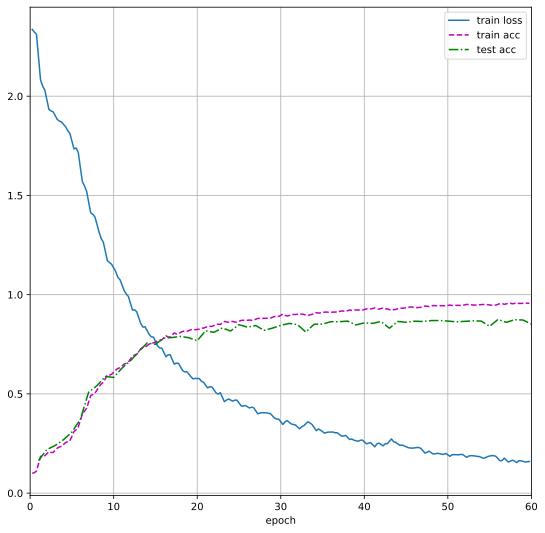

In [13]:
# please change to 100 if required
num_epochs = 60
trainf(bb_net, train_iter, test_iter, loss, num_epochs, optimizer, scheduler, device)

In [14]:
# torch.save(bb_net, "cifar10_88.model")

### END